In [126]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer


In [87]:
postCSV = pd.read_csv("Posts.csv", encoding= 'unicode_escape')


postCSV['Text'] = postCSV['Text'].str.replace('[\.]+', '.')
postCSV['Text'] = postCSV['Text'].str.replace('[\,]+', ',')
postCSV['Text'] = postCSV['Text'].str.replace('[\?]+', '?')
postCSV['Text'] = postCSV['Text'].str.replace('[\!]+', '!')
postCSV['Text'] = postCSV['Text'].str.replace('(#(\w)+)', '')
postCSV['Text'] = postCSV['Text'].str.replace('(@(\w)+)', '')
postCSV['Text'] = postCSV['Text'].str.replace('&', 'and')
postCSV['Text'] = postCSV['Text'].str.replace('a-z0-9\.\?\:\. |', '')
postCSV['Text'] = postCSV['Text'].str.replace('<[^<>]+>', '')
postCSV['Text'] = postCSV['Text'].str.replace('[0-9]+', 'number')
postCSV['Text'] = postCSV['Text'].str.replace('(http|https)://[^\s]*', '')

postCSV['Text'] = postCSV['Text'].str.replace('gonna', 'going to')
postCSV['Text'] = postCSV['Text'].str.replace('gotta', 'got to')
postCSV['Text'] = postCSV['Text'].str.replace('yall', 'you all')
postCSV['Text'] = postCSV['Text'].str.replace('im', 'i am')
postCSV['Text'] = postCSV['Text'].str.replace('id', 'i would')
postCSV['Text'] = postCSV['Text'].str.replace('idk', 'i do not know')
postCSV['Text'] = postCSV['Text'].str.replace('kms', 'kill myself')
postCSV['Text'] = postCSV['Text'].str.replace('tf', 'the fuck')
postCSV['Text'] = postCSV['Text'].str.replace('wtf', 'what the fuck')
postCSV['Text'] = postCSV['Text'].str.replace('stfu', 'shut the fuck up')
postCSV['Text'] = postCSV['Text'].str.replace('fk', 'fuck')
postCSV['Text'] = postCSV['Text'].str.replace('rly', 'really')
postCSV['Text'] = postCSV['Text'].str.replace('cant', 'can not')
postCSV['Text'] = postCSV['Text'].str.replace('dont', 'do not')
postCSV['Text'] = postCSV['Text'].str.replace('didnt', 'did not')
postCSV['Text'] = postCSV['Text'].str.replace('doesnt', 'does not')
postCSV['Text'] = postCSV['Text'].str.replace('wouldnt', 'would not')
postCSV['Text'] = postCSV['Text'].str.replace('hasnt', 'has not')
postCSV['Text'] = postCSV['Text'].str.replace('havent', 'have not')
postCSV['Text'] = postCSV['Text'].str.replace('shes', 'she is')
postCSV['Text'] = postCSV['Text'].str.replace('hes', 'he is')
postCSV['Text'] = postCSV['Text'].str.replace('its', 'it is')
postCSV['Text'] = postCSV['Text'].str.replace('isnt', 'is not')
postCSV['Text'] = postCSV['Text'].str.replace('arent', 'are not')
postCSV['Text'] = postCSV['Text'].str.replace('lemme', 'let me')
postCSV['Text'] = postCSV['Text'].str.replace('imma', 'i am going to')


In [145]:
x_value = postCSV['Text'].values
y_value = postCSV['Ideation'].values

x_train, x_test, y_train, y_test = train_test_split(x_value, y_value, test_size = 0.25, random_state = None)

In [146]:
tokenizer = Tokenizer(num_words = 5000)
tokenizer.fit_on_texts(x_train)

X_train = tokenizer.texts_to_sequences(x_train)
X_test = tokenizer.texts_to_sequences(x_test)

vocab_size = len(tokenizer.word_index) + 1

In [147]:
maxlen = 50
X_train = pad_sequences(X_train, padding = 'post', maxlen = maxlen)
X_test = pad_sequences(X_test, padding = 'post', maxlen = maxlen)

In [148]:
encoder = OneHotEncoder(sparse = False)

y_train = y_train.reshape((len(y_train), 1))
y_train = encoder.fit_transform(y_train)

y_test = y_test.reshape((len(y_test), 1))
y_test = encoder.fit_transform(y_test)

In [149]:
plt.style.use('ggplot')
def plot_history(history):
    a = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    l = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(a) + 1)
    
    plt.figure(figsize = (12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, a, 'b', label = 'Training accuracy')
    plt.plot(x, val_acc, 'r', label = 'Validation accuracy')
    plt.title('Training and validation acccuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(x, l, 'b', label = 'Training loss')
    plt.plot(x, val_loss, 'r', label = 'Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [150]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    
    with open(filepath) as f:
        for line in f:
            val = line.split()
            if val[0] is word_index:
                ind = word_index[val[0]]
                embedding_matrix[ind] = np.array(val[1:embedding_dim + 1], 
                             'float 32')
                
    return embedding_matrix

embedding_matrix = create_embedding_matrix('glove.twitter.27B.50d.txt', 
                      tokenizer.word_index, 
                      50)

In [ ]:
#Long Short-Term Memory
model = Sequential()
model.add(layers.Embedding(input_dim = vocab_size, 
              output_dim = embedding_dim,
              weights = [embedding_matrix],
              input_length = maxlen,
              trainable = True))
model.add(layers.Conv1D(32, 3, padding = 'valid', strides = 1, activation = 'relu'))
model.add(layers.MaxPool1D(3, 1, padding = 'valid'))
model.add(layers.Dropout(0.3))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(16, activation = 'relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(3, activation = 'softmax'))


In [ ]:
#Gated recurrent units
model = Sequential()
model.add(layers.Embedding(input_dim = vocab_size, 
              output_dim = embedding_dim,
              weights = [embedding_matrix],
              input_length = maxlen,
              trainable = True))
model.add(layers.Conv1D(48, 3, padding = 'valid', strides = 1, activation = 'relu'))
model.add(layers.MaxPool1D(3, 1, padding = 'valid'))
model.add(layers.Dropout(0.3))
model.add(layers.GRU(48, return_sequences = True))
model.add(layers.GRU(12, return_sequences = False))
model.add(layers.Dropout(0.3))
model.add(layers.SimpleRNN(12))
model.add(layers.Dense(3, activation = 'softmax'))


In [ ]:
#Convolutional neural network
model = Sequential()
model.add(layers.Embedding(input_dim = vocab_size, 
              output_dim = embedding_dim,
              weights = [embedding_matrix],
              input_length = maxlen,
              trainable = True))
model.add(layers.Conv1D(32, 4, padding = 'valid', strides = 1, activation = 'relu'))
model.add(layers.MaxPool1D(2, 1))
model.add(layers.Dropout(0.2))
model.add(layers.Conv1D(32, 3, padding = 'valid', strides = 1, activation = 'relu'))
model.add(layers.MaxPool1D(2, 1))
model.add(layers.Dropout(0.2))
model.add(layers.Conv1D(32, 2, padding = 'valid', strides = 1, activation = 'relu'))
model.add(layers.MaxPool1D(2, 1))
model.add(layers.Dropout(0.2))
model.add(layers.Flatten())
model.add(layers.Dense(16, activation = 'relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(3, activation = 'softmax'))


In [152]:
#Model
model = Sequential()
model.add(layers.Embedding(input_dim = vocab_size, 
              output_dim = embedding_dim,
              weights = [embedding_matrix],
              input_length = maxlen,
              trainable = True))
model.add(layers.Conv1D(32, 4, padding = 'valid', strides = 1, activation = 'relu'))
model.add(layers.MaxPool1D(pool_size = 2, strides = 1, padding = 'valid'))
model.add(layers.Dropout(0.3))
model.add(layers.Conv1D(32, 3, padding = 'valid', strides = 1, activation = 'relu'))
model.add(layers.MaxPool1D(2, 1))
model.add(layers.Dropout(0.3))
model.add(layers.Conv1D(32, 2, padding = 'valid', strides = 1, activation = 'relu'))
model.add(layers.MaxPool1D(2, 1))
model.add(layers.Dropout(0.2))

model.add(layers.GRU(36, return_sequences = True))
model.add(layers.GRU(12, return_sequences = False))
model.add(layers.Dense(16, activation = 'relu'))
model.add(layers.Flatten())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(3, activation = 'softmax'))

model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',
              metrics = ['accuracy'])



In [154]:
hist = model.fit(X_train, y_train, epochs = 30, verbose = 2, batch_size = 20, validation_data = (X_test, y_test))

loss, accuracy = model.evaluate(X_train, y_train, verbose = False)
print('Training Accuracy: {:.4f}'.format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose = False)
print('Testing Accuracy: {:.4f}'.format(accuracy))

Epoch 1/30
50/50 - 2s - loss: 1.0750 - accuracy: 0.4975 - val_loss: 1.0799 - val_accuracy: 0.4364
Epoch 2/30
50/50 - 2s - loss: 1.0669 - accuracy: 0.4975 - val_loss: 1.0754 - val_accuracy: 0.4364
Epoch 3/30
50/50 - 2s - loss: 1.0606 - accuracy: 0.4975 - val_loss: 1.0726 - val_accuracy: 0.4364
Epoch 4/30
50/50 - 2s - loss: 1.0555 - accuracy: 0.4975 - val_loss: 1.0700 - val_accuracy: 0.4364
Epoch 5/30
50/50 - 2s - loss: 1.0513 - accuracy: 0.4975 - val_loss: 1.0684 - val_accuracy: 0.4364
Epoch 6/30
50/50 - 2s - loss: 1.0480 - accuracy: 0.4975 - val_loss: 1.0670 - val_accuracy: 0.4364
Epoch 7/30
50/50 - 2s - loss: 1.0452 - accuracy: 0.4975 - val_loss: 1.0659 - val_accuracy: 0.4364
Epoch 8/30
50/50 - 2s - loss: 1.0428 - accuracy: 0.4975 - val_loss: 1.0657 - val_accuracy: 0.4364
Epoch 9/30
50/50 - 2s - loss: 1.0412 - accuracy: 0.4975 - val_loss: 1.0656 - val_accuracy: 0.4364
Epoch 10/30
50/50 - 2s - loss: 1.0398 - accuracy: 0.4975 - val_loss: 1.0650 - val_accuracy: 0.4364
Epoch 11/30
50/50 -

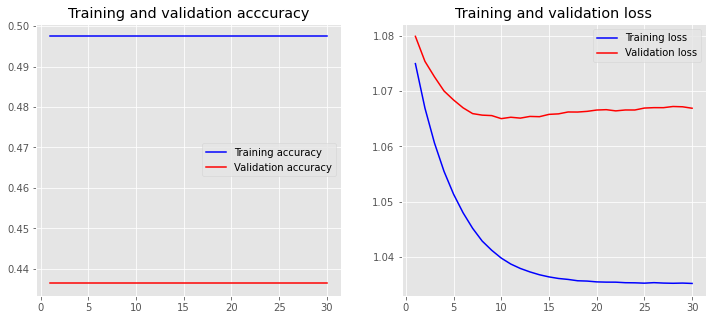

In [155]:
plot_history(hist)

In [112]:
prediction_train = [i.argmax() for i in model.predict(X_train)]
prediction_test = [i.argmax() for i in model.predict(X_test)]

Y_train_hat = np.array(prediction_train)
Y_test_hat = np.array(prediction_test)
Y_train = np.array([i.argmax() for i in y_train])
Y_test = np.array([i.argmax() for i in y_test])

tp = sum((Y_test == Y_test_hat) & (Y_test == 2))
tn = sum((Y_test == Y_test_hat) & (Y_test != 2))
fp = sum((Y_test != Y_test_hat) & (Y_test_hat == 2))
fn = sum((Y_test != Y_test_hat) & (Y_test == 2))

precision = tp/(tp+fp)
recall = tp/(tp+fn)

f1 = 2 * precision * recall / (precision + recall)
precision, recall, f1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in long_scalars
  


(nan, 0.0, nan)

In [114]:
from tensorflow.keras.models import model_from_json

jsonModel = model.to_json()
with open("model101.json", "w") as json_file:
  json_file.write(jsonModel)

model.save_weights("model101.h5")